# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
# !pip3 install torch torchvision

# !wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
# device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [33]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [34]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [9]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.FloatTensor)
# nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [11]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x
            y_gpu = y
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!

    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x
        y_gpu = y
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
    accuracy = float(correct_samples) / total_samples

    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.681132, Train accuracy: 0.794117, Val accuracy: 0.818306
Average loss: 0.574947, Train accuracy: 0.827646, Val accuracy: 0.802061
Average loss: 0.531896, Train accuracy: 0.841433, Val accuracy: 0.833800
Average loss: 0.504308, Train accuracy: 0.850203, Val accuracy: 0.843765
Average loss: 0.476864, Train accuracy: 0.857830, Val accuracy: 0.842605


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [13]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),# resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./data/', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

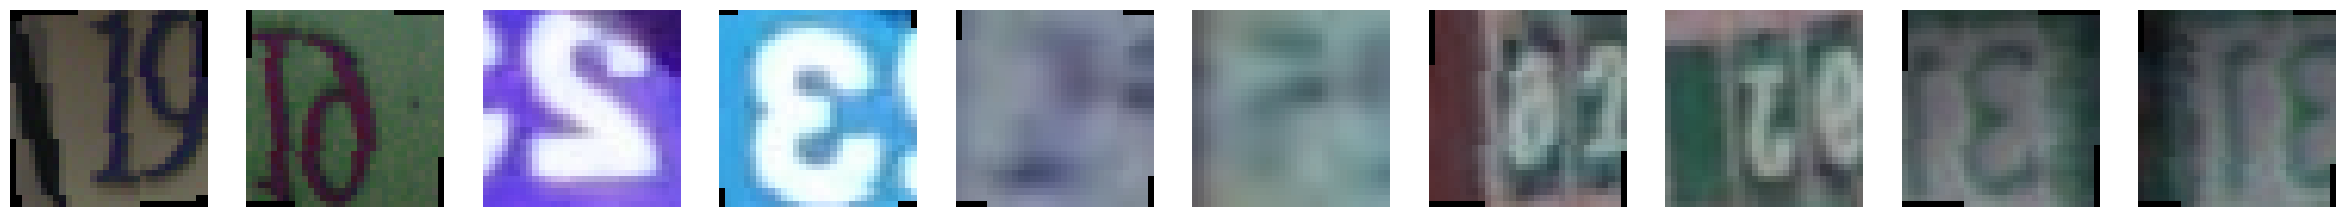

In [15]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),# resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./data/', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [37]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./data/', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [18]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 1.602376, Train accuracy: 0.447838, Val accuracy: 0.610402
Average loss: 1.369103, Train accuracy: 0.524810, Val accuracy: 0.647055
Average loss: 1.302281, Train accuracy: 0.548800, Val accuracy: 0.639479
Average loss: 1.260059, Train accuracy: 0.566273, Val accuracy: 0.636544
Average loss: 1.229030, Train accuracy: 0.574259, Val accuracy: 0.647260


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [38]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential( #3 * 32 * 32
    nn.Conv2d(3, 6, kernel_size=5, padding=2), #6 * 32 * 32
    nn.ReLU(inplace=True), #6 * 32 * 32
    nn.MaxPool2d(kernel_size=2, stride=2), #6 * 16 * 16
    nn.Conv2d(6, 16, kernel_size=5, padding=0),  #16 * 12 * 12
    nn.MaxPool2d(kernel_size=2, stride=2),#16 * 6 * 6
    Flattener(),
    nn.Linear(16 * 6 * 6, 120),
    nn.ReLU(inplace=True),
    nn.Linear(120, 84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10),
    )

lenet_model.type(torch.FloatTensor)
# lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [39]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.838374, Train accuracy: 0.345152, Val accuracy: 0.572316
Average loss: 1.095180, Train accuracy: 0.623213, Val accuracy: 0.677565
Average loss: 0.936493, Train accuracy: 0.680869, Val accuracy: 0.705890
Average loss: 0.859895, Train accuracy: 0.703341, Val accuracy: 0.734626
Average loss: 0.811025, Train accuracy: 0.719653, Val accuracy: 0.730121
Average loss: 0.785174, Train accuracy: 0.729840, Val accuracy: 0.756672
Average loss: 0.765445, Train accuracy: 0.736563, Val accuracy: 0.773258
Average loss: 0.746795, Train accuracy: 0.742654, Val accuracy: 0.768753
Average loss: 0.732684, Train accuracy: 0.745640, Val accuracy: 0.774009
Average loss: 0.721359, Train accuracy: 0.750879, Val accuracy: 0.771893


# Подбор гиперпараметров

In [41]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

In [57]:
import random
from optim import SGD, MomentumSGD
from tqdm import tqdm

In [51]:
params_grid = [learning_rates, anneal_epochs, reg]


In [58]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size):
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

    loss_history = []
    train_history = []
    val_history = []
    for epoch in tqdm(range(num_epochs)):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x
            y_gpu = y
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [59]:
n_results = 10
for i in range(n_results):
    params = [random.sample(param, 1)[0] for param in params_grid]
    print(f"lr={params[0]}, anneal_epochs={params[1]}, reg={params[2]}")

    optimizer = optim.SGD(lenet_model.parameters(), lr=params[0], weight_decay=params[2], momentum=0.9)
    _, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, params[1])
    run_record[Hyperparams(*params)] = RunResult(lenet_model, train_history, val_history, val_history[-1])
    print("final_val_accuracy:", val_history[-1])
    print("\n")

lr=0.001, anneal_epochs=5, reg=1e-05


 10%|█         | 1/10 [00:27<04:05, 27.27s/it]

Average loss: 0.602210, Train accuracy: 0.791011, Val accuracy: 0.797147


 20%|██        | 2/10 [00:54<03:37, 27.16s/it]

Average loss: 0.585409, Train accuracy: 0.793417, Val accuracy: 0.805338


 30%|███       | 3/10 [01:21<03:09, 27.05s/it]

Average loss: 0.575106, Train accuracy: 0.797171, Val accuracy: 0.790799


 40%|████      | 4/10 [01:47<02:41, 26.85s/it]

Average loss: 0.569593, Train accuracy: 0.798860, Val accuracy: 0.796942


 50%|█████     | 5/10 [02:14<02:13, 26.78s/it]

Average loss: 0.560651, Train accuracy: 0.801607, Val accuracy: 0.803495


 60%|██████    | 6/10 [02:42<01:48, 27.23s/it]

Average loss: 0.558733, Train accuracy: 0.803160, Val accuracy: 0.813938


 70%|███████   | 7/10 [03:08<01:20, 26.96s/it]

Average loss: 0.552019, Train accuracy: 0.803808, Val accuracy: 0.803563


 80%|████████  | 8/10 [03:35<00:53, 26.71s/it]

Average loss: 0.545917, Train accuracy: 0.805532, Val accuracy: 0.800491


 90%|█████████ | 9/10 [04:01<00:26, 26.54s/it]

Average loss: 0.547220, Train accuracy: 0.805259, Val accuracy: 0.812436


100%|██████████| 10/10 [04:28<00:00, 26.81s/it]


Average loss: 0.543320, Train accuracy: 0.806453, Val accuracy: 0.809023
final_val_accuracy: 0.8090232748617842


lr=0.001, anneal_epochs=1, reg=1e-05


 10%|█         | 1/10 [00:26<03:55, 26.21s/it]

Average loss: 0.540159, Train accuracy: 0.808620, Val accuracy: 0.804791


 20%|██        | 2/10 [00:52<03:30, 26.32s/it]

Average loss: 0.540759, Train accuracy: 0.807870, Val accuracy: 0.807658


 30%|███       | 3/10 [01:18<03:03, 26.27s/it]

Average loss: 0.535283, Train accuracy: 0.811436, Val accuracy: 0.802471


 40%|████      | 4/10 [01:45<02:37, 26.25s/it]

Average loss: 0.532197, Train accuracy: 0.811419, Val accuracy: 0.807999


 50%|█████     | 5/10 [02:12<02:13, 26.67s/it]

Average loss: 0.527523, Train accuracy: 0.814149, Val accuracy: 0.816531


 60%|██████    | 6/10 [02:38<01:46, 26.55s/it]

Average loss: 0.530025, Train accuracy: 0.812732, Val accuracy: 0.802676


 70%|███████   | 7/10 [03:05<01:19, 26.53s/it]

Average loss: 0.529053, Train accuracy: 0.811982, Val accuracy: 0.816600


 80%|████████  | 8/10 [03:31<00:52, 26.39s/it]

Average loss: 0.521838, Train accuracy: 0.813466, Val accuracy: 0.808341


 90%|█████████ | 9/10 [03:57<00:26, 26.35s/it]

Average loss: 0.522811, Train accuracy: 0.814985, Val accuracy: 0.807522


100%|██████████| 10/10 [04:23<00:00, 26.40s/it]


Average loss: 0.522017, Train accuracy: 0.814268, Val accuracy: 0.823630
final_val_accuracy: 0.8236297863627056


lr=0.1, anneal_epochs=15, reg=1e-05


 10%|█         | 1/10 [00:27<04:03, 27.06s/it]

Average loss: nan, Train accuracy: 0.073747, Val accuracy: 0.067572


 20%|██        | 2/10 [00:54<03:38, 27.28s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 30%|███       | 3/10 [01:21<03:09, 27.13s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 40%|████      | 4/10 [01:48<02:42, 27.01s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 50%|█████     | 5/10 [02:14<02:13, 26.79s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 60%|██████    | 6/10 [02:41<01:47, 26.76s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 70%|███████   | 7/10 [03:08<01:20, 26.87s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 80%|████████  | 8/10 [03:35<00:53, 26.86s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 90%|█████████ | 9/10 [04:02<00:27, 27.05s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


100%|██████████| 10/10 [04:29<00:00, 26.91s/it]


Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572
final_val_accuracy: 0.06757217937342161


lr=1.0, anneal_epochs=1, reg=1e-07


 10%|█         | 1/10 [00:27<04:03, 27.04s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 20%|██        | 2/10 [00:55<03:42, 27.75s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 30%|███       | 3/10 [01:22<03:13, 27.63s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 40%|████      | 4/10 [01:50<02:46, 27.73s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 50%|█████     | 5/10 [02:16<02:15, 27.19s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 60%|██████    | 6/10 [02:45<01:50, 27.56s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 70%|███████   | 7/10 [03:11<01:21, 27.12s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 80%|████████  | 8/10 [03:37<00:53, 26.92s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 90%|█████████ | 9/10 [04:04<00:26, 26.82s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


100%|██████████| 10/10 [04:31<00:00, 27.14s/it]


Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572
final_val_accuracy: 0.06757217937342161


lr=0.001, anneal_epochs=15, reg=0.0001


 10%|█         | 1/10 [00:26<04:00, 26.72s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 20%|██        | 2/10 [00:52<03:31, 26.40s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 30%|███       | 3/10 [01:19<03:03, 26.29s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 40%|████      | 4/10 [01:45<02:37, 26.21s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 50%|█████     | 5/10 [02:11<02:10, 26.12s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 60%|██████    | 6/10 [02:37<01:45, 26.27s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 70%|███████   | 7/10 [03:04<01:19, 26.44s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 80%|████████  | 8/10 [03:30<00:52, 26.34s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 90%|█████████ | 9/10 [03:56<00:26, 26.27s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


100%|██████████| 10/10 [04:22<00:00, 26.28s/it]


Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572
final_val_accuracy: 0.06757217937342161


lr=0.0001, anneal_epochs=15, reg=0.001


 10%|█         | 1/10 [00:26<03:55, 26.13s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 20%|██        | 2/10 [00:52<03:29, 26.15s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 30%|███       | 3/10 [01:18<03:02, 26.13s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 40%|████      | 4/10 [01:44<02:36, 26.16s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 50%|█████     | 5/10 [02:10<02:10, 26.13s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 60%|██████    | 6/10 [02:36<01:44, 26.12s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 70%|███████   | 7/10 [03:02<01:18, 26.14s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 80%|████████  | 8/10 [03:29<00:52, 26.12s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 90%|█████████ | 9/10 [03:55<00:26, 26.16s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


100%|██████████| 10/10 [04:21<00:00, 26.13s/it]


Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572
final_val_accuracy: 0.06757217937342161


lr=0.0001, anneal_epochs=20, reg=0.0001


 10%|█         | 1/10 [00:26<03:55, 26.21s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 20%|██        | 2/10 [00:52<03:28, 26.12s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 30%|███       | 3/10 [01:18<03:02, 26.13s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 40%|████      | 4/10 [01:44<02:36, 26.15s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 50%|█████     | 5/10 [02:10<02:10, 26.16s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 60%|██████    | 6/10 [02:36<01:44, 26.12s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 70%|███████   | 7/10 [03:02<01:18, 26.14s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 80%|████████  | 8/10 [03:29<00:52, 26.23s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 90%|█████████ | 9/10 [03:55<00:26, 26.27s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


100%|██████████| 10/10 [04:21<00:00, 26.18s/it]


Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572
final_val_accuracy: 0.06757217937342161


lr=0.01, anneal_epochs=15, reg=0.001


 10%|█         | 1/10 [00:25<03:52, 25.87s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 20%|██        | 2/10 [00:51<03:26, 25.82s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 30%|███       | 3/10 [01:17<03:01, 25.87s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 40%|████      | 4/10 [01:43<02:35, 25.85s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 50%|█████     | 5/10 [02:09<02:09, 25.84s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 60%|██████    | 6/10 [02:35<01:43, 25.84s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 70%|███████   | 7/10 [03:00<01:17, 25.85s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 80%|████████  | 8/10 [03:27<00:52, 26.05s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 90%|█████████ | 9/10 [03:53<00:26, 26.04s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


100%|██████████| 10/10 [04:19<00:00, 25.96s/it]


Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572
final_val_accuracy: 0.06757217937342161


lr=0.001, anneal_epochs=50, reg=0.0001


 10%|█         | 1/10 [00:26<03:56, 26.32s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 20%|██        | 2/10 [00:52<03:29, 26.13s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 30%|███       | 3/10 [01:18<03:02, 26.11s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 40%|████      | 4/10 [01:44<02:36, 26.09s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 50%|█████     | 5/10 [02:10<02:10, 26.12s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 60%|██████    | 6/10 [02:36<01:44, 26.11s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 70%|███████   | 7/10 [03:02<01:18, 26.10s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 80%|████████  | 8/10 [03:28<00:52, 26.12s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 90%|█████████ | 9/10 [03:54<00:26, 26.05s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


100%|██████████| 10/10 [04:20<00:00, 26.10s/it]


Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572
final_val_accuracy: 0.06757217937342161


lr=0.0001, anneal_epochs=1, reg=0.0001


 10%|█         | 1/10 [00:26<03:54, 26.07s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 20%|██        | 2/10 [00:52<03:28, 26.05s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 30%|███       | 3/10 [01:18<03:02, 26.07s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 40%|████      | 4/10 [01:44<02:36, 26.06s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 50%|█████     | 5/10 [02:10<02:10, 26.07s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 60%|██████    | 6/10 [02:36<01:44, 26.17s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 70%|███████   | 7/10 [03:02<01:18, 26.18s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 80%|████████  | 8/10 [03:29<00:52, 26.18s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


 90%|█████████ | 9/10 [03:55<00:26, 26.14s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572


100%|██████████| 10/10 [04:21<00:00, 26.13s/it]

Average loss: nan, Train accuracy: 0.067536, Val accuracy: 0.067572
final_val_accuracy: 0.06757217937342161




In [60]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.82, best hyperparams: Hyperparams(learning_rate=0.001, anneal_epochs=1, reg=1e-05)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [ ]:
best_model = None

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [66]:
batch_size = 64

data_size = data_train.data.shape[0]
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices = indices

train_sampler = SubsetRandomSampler(train_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)


In [72]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)


In [67]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./data/', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [71]:
data_test = dset.SVHN('./data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

In [76]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size):
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

    loss_history = []
    train_history = []
    val_history = []
    for epoch in tqdm(range(num_epochs)):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x
            y_gpu = y
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [77]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential( #3 * 32 * 32
    nn.Conv2d(3, 6, kernel_size=5, padding=2), #6 * 32 * 32
    nn.ReLU(inplace=True), #6 * 32 * 32
    nn.MaxPool2d(kernel_size=2, stride=2), #6 * 16 * 16
    nn.Conv2d(6, 16, kernel_size=5, padding=0),  #16 * 12 * 12
    nn.MaxPool2d(kernel_size=2, stride=2),#16 * 6 * 6
    Flattener(),
    nn.Linear(16 * 6 * 6, 120),
    nn.ReLU(inplace=True),
    nn.Linear(120, 84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10),
    )

lenet_model.type(torch.FloatTensor)
# lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

optimizer = optim.SGD(lenet_model.parameters(), lr=0.001, weight_decay=1e-05, momentum=0.9)


In [78]:
_, train_history, val_history = train_model(lenet_model, train_aug_loader, test_loader, loss, optimizer, epoch_num, 1)


 10%|█         | 1/10 [00:33<05:04, 33.82s/it]

Average loss: 2.247499, Train accuracy: 0.185757, Val accuracy: 0.195874


 20%|██        | 2/10 [01:07<04:31, 33.88s/it]

Average loss: 2.179873, Train accuracy: 0.216566, Val accuracy: 0.321604


 30%|███       | 3/10 [01:41<03:56, 33.81s/it]

Average loss: 1.778885, Train accuracy: 0.369043, Val accuracy: 0.451752


 40%|████      | 4/10 [02:15<03:22, 33.72s/it]

Average loss: 1.400661, Train accuracy: 0.507951, Val accuracy: 0.565496


 50%|█████     | 5/10 [02:48<02:47, 33.60s/it]

Average loss: 1.205274, Train accuracy: 0.587466, Val accuracy: 0.628073


 60%|██████    | 6/10 [03:22<02:15, 33.77s/it]

Average loss: 1.088901, Train accuracy: 0.633155, Val accuracy: 0.645436


 70%|███████   | 7/10 [03:56<01:41, 33.76s/it]

Average loss: 1.012053, Train accuracy: 0.659691, Val accuracy: 0.666449


 80%|████████  | 8/10 [04:29<01:07, 33.58s/it]

Average loss: 0.959268, Train accuracy: 0.674693, Val accuracy: 0.682276


 90%|█████████ | 9/10 [05:02<00:33, 33.42s/it]

Average loss: 0.919671, Train accuracy: 0.688521, Val accuracy: 0.695029


100%|██████████| 10/10 [05:36<00:00, 33.62s/it]

Average loss: 0.888038, Train accuracy: 0.696561, Val accuracy: 0.698294


In [79]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(lenet_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.6983
